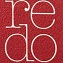

#**Comic Book Scraper for Redo Inc.**

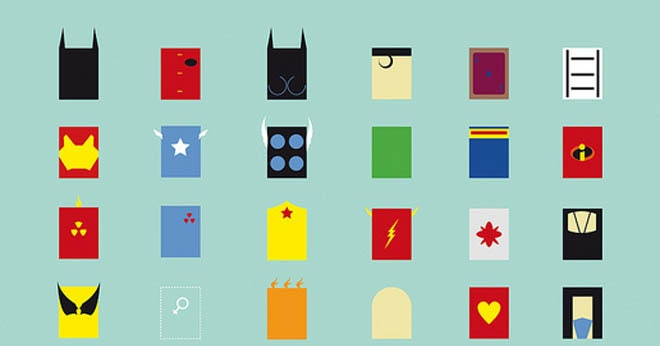

At work recently, I had the task of pricing  **14 long boxes of comics** in two days. Each long box contains approximately 275 comics that my boss wantedcorrectly cataloged and priced. Since I was the only working on pricing for this collection of nearly **4000 comics** , I needed a way to price this collection quickly and accurately before the sale.






Instead of doing this entire process manually, I realized I could use my skills in Python and web scraping to optimize this whole process. I found a site, mycomicbookshop.com, that conveniently provides a price and an "Add to Cart Option" for most of the comics in the collection. To efficiently create an accurate list, I put the exact comics in the collection to the cart where I could confirm each entry was accurate and confirm the condition of each comic. From there I wanted scrape all the information I could for each entry.




**Some things to note before continuing**: 


> 0. The owner of this collection of comics is not comfortable with the contents of his entire collection being posted online at this time, so this project will only be on the contents of approximately three long boxes selected at random. So analysis will be done separately based on a sample of about 600 of those comics.
1. Simple visualizations will be performed, but most of the EDA was completed in Tableau.
2. An explanation for the comic book grading system can be found [here](https://www.mycomicshop.com/help/grading), for those unfamiliar with how the system works.
3. After conversing with some people in the comic collecting community about this project, I was informed that the prices on mycomicbookshop.com are slightly overpriced. To compensate for this, we took 25% off the calculated price in addition to the discount we gave on the entire lot.
4. I had some help writing this code, and I would like to thank user doctorevil92 for helping me get past the 503-gateway error. I could not have done this without him and wanted to acknowledge him for his assistance.
5. This code was functioning as of November 2019, format changes and comments were updated as of November 2021.


My approach will be as follows:


0.   Import packages
1.   Make functions to avoid time-out errors and to clean scraped data
2.   Make a function to scrape attributes based on XPath for each comic
3.   Login and navigate to cart using Selenium
4.   Append all the items in the cart to a list, navigate to each item's URL, and then scrape elements
6.   Parse scraped elements and create a CSV



In [27]:
# specifying username and password, you can enter your own here!

USERNAME = "myusername"
PASSWORD = "mypassword"

## 0. Imports

In [32]:
# imports
from selenium import webdriver
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.keys import Keys

import time
import pprint
import os
import sys
from datetime import datetime

from lxml import html
import csv
import sqlite3

##1.   Make functions to avoid time-out errors and to clean scraped data

In [28]:
TIME_PAUSE = 1.0 # this is a pause to prevent error

def wait_by_xpath(xp, how_long_to_wait):
  '''
  So this how long the time out should be for each step in an Xpath, this will wait until an item loads 
  and the bot can locate the lift modeling.
  xp is the string and  how_long_to_wait float is the number of seconds to wait
  '''
  try:
      WebDriverWait(driver, how_long_to_wait).until(EC.presence_of_element_located((By.XPATH, xp)) )
      time.sleep(TIME_PAUSE)
      return 1 # 1 will be a success
  except TimeoutException:
      print ("Too much time has passed while waiting for", xp)
      return 0 # 0 will be a failure

In [22]:
def fix_string(entry_string):
  '''
  Function to remove "\n", "\t" and double spaces
  ''' 
  exit_string = entry_string.replace("\n", "")
  exit_string = exit_string.replace("\t", "")
  exit_string = exit_string.replace("\r", "")
  
  while "  " in exit_string:
      exit_string = exit_string.replace("  ", " ")
  if len(exit_string) > 0: # remove first space
      if exit_string[0] == ' ':
          exit_string = exit_string[1:len(exit_string)]
  if len(exit_string) > 0: # remove last space
      if exit_string[len(exit_string)-1] == ' ':
          exit_string = exit_string[0:len(exit_string)-1]

  return exit_string

### 2.   Make a function to scrape attributes based on XPath for each comic

In [29]:
def PARSE(input_url, input_name, input_price, input_html):

  '''
  Function to extract elements for each comic book in cart.
  Will extract the title, series, condition, the publisher, the month of publication, the year of publication
  any tags the comic has on the site, the description, the cover price, the full price', and the comic's URL on mycomicshop.com.
  '''
  data_to_return = {}
  data_to_return["URL"] = input_url
  data_to_return["Full Price"] = input_price

  tree = html.document_fromstring(input_html)

  data_to_return["Title"] = ''
  data_to_return["Series"] = ''
  data_to_return["Condition"] = ''
  full_title_text = input_name
  data_to_return["Title"] = full_title_text

  if "(" in full_title_text and ")" in full_title_text:
      if full_title_text.find("(") < full_title_text.find(")"):
          data_to_return["Series"] = full_title_text[full_title_text.find("(")+1 : full_title_text.find(")")]

          data_to_return["Condition"] = fix_string("".join(char for char in full_title_text[full_title_text.find(")")+1 : len(full_title_text)] if not char.isdigit()))

  
  data_to_return["Month Published"] = ''
  data_to_return["Year Published"] = ''
  published_el = tree.xpath("//div[@class='primary']//div/text()[contains(., 'Published')]/following-sibling::a[@href][1]")
  if len(published_el) != 0:
      published_time_fullstring = fix_string(published_el[0].text_content())
      published_time_array = [pub_item for pub_item in published_time_fullstring.split(" ") if pub_item!='']
      if len(published_time_array) == 1:
          # trying to get year only
          try:
              probe_year = int(published_time_array[0])
              data_to_return["Year Published"] = probe_year
          except ValueError:
              print ("Unable to parse year of publishing with 1 element on URL", input_url)
              pass

      elif len(published_time_array) == 2:
          # output should be month and year
          try:
              probe_year = int(published_time_array[1])
              data_to_return["Year Published"] = probe_year
              data_to_return["Month Published"] = published_time_array[0]
          except ValueError:
              print ("Unable to parse year of publishing with 2 elements on URL", input_url)
              pass
      else:
          print ("Unknown form of date for", published_time_array)


  data_to_return["Publisher"] = ''
  publisher_el = tree.xpath("//div[@class='primary']//div/text()[contains(., 'Published')]/following-sibling::text()[contains(., 'by')]/following-sibling::a[@href][1]")
  if len(publisher_el) != 0:
      data_to_return["Publisher"] = publisher_el[0].text_content()

  data_to_return["Tags"] = ''
  tags_els = tree.xpath("//div[@class='primary']//div[@class='title']/following-sibling::div/text()[contains(., 'Tags')]/following-sibling::a[@href]")
  for tag_el in tags_els:
      data_to_return["Tags"] = data_to_return["Tags"] + tag_el.text_content() + ", "
  data_to_return["Tags"] = data_to_return["Tags"][0:data_to_return["Tags"].rfind(", ")]

  data_to_return["Description"] = ''
  descr_el = tree.xpath("//div[@class='primary']//div[@class='tabcontents']/div[@class='issuegrades']/following-sibling::p[1]/text()")
  if len(descr_el) != 0:
      data_to_return["Description"] = descr_el[0]

  data_to_return["Cover Price"] = '' # get from description text
  if len(descr_el) != 0:
      descr_to_parse = descr_el[0].lower()
      cover_price_text = fix_string(descr_to_parse[descr_to_parse.rfind("cover price")+len("cover price") : descr_to_parse.rfind(".")])
      try:
          probe_price = float(cover_price_text.replace("$", ""))
          data_to_return["Cover Price"] = cover_price_text
      except ValueError:
          pass
  
  return data_to_return

### 3.   Login and navigate to cart using Selenium

In [ ]:
# Create a webdriver in Firefox
driver = webdriver.Firefox(executable_path=GeckoDriverManager().install())
driver.maximize_window()

In [ ]:
## first, try to login

# go to login page
try:
    driver.get("https://www.mycomicshop.com/login")
except:
    print ("Some kind of exception, quit!")
    driver.quit()
    sys.exit(0)

# Find credential xpath and input username and password
try:
    username_el = driver.find_element_by_xpath("//input[@name='CustomerEmail']")
    username_el.send_keys(USERNAME)
    password_el = driver.find_element_by_xpath("//input[@name='CustomerPassword']")
    password_el.send_keys(PASSWORD)
    login_el = driver.find_element_by_xpath("//input[@type='submit' and @value='Log In']")
    driver.execute_script("arguments[0].click();", login_el)
    time.sleep(5.0)
except:
    print ("Some kind of exception while logging in, quit!")
    driver.quit()
    sys.exit(0)

#navigate to the cart
try:
    driver.get("https://www.mycomicshop.com/cart")
    wait_for_cart = wait_by_xpath("//h2[text()='Saved For Later']/following-sibling::table[1]/tbody/tr/td[1]/a[contains(@href, 'search?')]/../..", 30)
    if wait_for_cart == 0:
        print ("Failed wait for cart elements, quit!")
        driver.quit()
        sys.exit(0)
    innerHTML_cart = driver.execute_script("return document.body.innerHTML")
    htmlElem_cart = html.document_fromstring(innerHTML_cart)
except:
    print ("Some kind of exception while opening cart link, quit!")
    driver.quit()
    sys.exit(0)
### login done

## 4.   Append all the items in the cart to a list, navigate to each item's URL, and then scrape elements

In [ ]:
### get a list of items from cart html, visit all urls that need to be visited

items_to_visit = [] # keys: name, url, price
comic_els = htmlElem_cart.xpath("//h2[text()='Saved For Later']/following-sibling::table[1]/tbody/tr/td[1]/a[contains(@href, 'search?')]/../..")
for comic_el in comic_els:
    comic_link_el = comic_el.xpath("./td[1]/a[@href]")
    comic_price_el = comic_el.xpath("./td[2]")

    if len(comic_link_el) != 0 and len(comic_price_el) != 0:
        items_to_visit.append( {"name":comic_link_el[0].text_content(), "price":fix_string(comic_price_el[0].text_content()), "url": "https://www.mycomicshop.com" + comic_link_el[0].attrib["href"]} )

# create a database, get already scraped links
db_conn = sqlite3.connect("COMICS_DB.db")
db_cursor = db_conn.cursor()
db_cursor.execute("CREATE TABLE IF NOT EXISTS ComicsData (url TEXT, name TEXT, price TEXT, html TEXT)")

already_scraped_links = {}
for already_scraped_item in db_cursor.execute("SELECT url FROM ComicsData"):
    already_scraped_links[already_scraped_item[0]] = ''

# now visit every comic url and save html if some kind of verificator is found.
for item_to_visit in items_to_visit:
    if item_to_visit["url"] in already_scraped_links:
        continue # this was already scraped

    # if here, try to open link
    try:
        driver.get(item_to_visit["url"])
        wait_for_verificator = wait_by_xpath("//div[@class='primary']/h1[@class='top']", 20)
        if wait_for_verificator == 0:
            continue
        innerHTML_cart = driver.execute_script("return document.body.innerHTML")
        htmlElem_cart = html.document_fromstring(innerHTML_cart)

    except KeyboardInterrupt:
        print ("Manual interrupt, quit everything!")
        driver.quit()
        db_cursor.close()
        db_conn.close()
        sys.exit(0)

    except:
        time.sleep(2.0)
        continue

    #if still here, save html, update scraped links and continue to the next one.
    db_cursor.execute("INSERT INTO ComicsData (url, name, price, html) VALUES (?,?,?,?)",
                  (item_to_visit["url"], item_to_visit["name"], item_to_visit["price"], innerHTML_cart) ) # not necessary to insert all columns!
    db_conn.commit()
    already_scraped_links[item_to_visit["url"]] = ''
    print ("Scraped link number", items_to_visit.index(item_to_visit)+1, "/", len(items_to_visit))

driver.quit()

### 5.Parse scraped elements and create a CSV

In [ ]:
### parse for all items in items_to_visit!

print ("Parsing listed comics...")
headers_in_order = ['Title', 'Series', 'Condition', 'Publisher', 'Month_Published', 'Year_Published', 'Tags', 'Description', 'Cover_Price', 'Full_Price', 'URL']
output_filename = datetime.now().strftime("%m-%d-%Y %H_%M_%S") + ".csv" # add
with open(output_filename, "w", newline="", encoding="utf-8") as csvfil:
    writer = csv.writer(csvfil, delimiter=";", quoting=csv.QUOTE_MINIMAL)
    writer.writerow(headers_in_order) # write headers
    
    for item_to_fetch in items_to_visit:
        # for each link, get data from database
        for fetched_data in db_cursor.execute("SELECT * FROM ComicsData WHERE url=?", (item_to_fetch["url"],)):
            parsed_data = PARSE(fetched_data[0], fetched_data[1], fetched_data[2], fetched_data[3]) #using function we defined earlier
            # write from parsed_data to csv
            row_to_write = [parsed_data[key_to_write] for key_to_write in headers_in_order]
            writer.writerow(row_to_write)
            break # only 1 result
        
print ("Output file:", output_filename)    
db_cursor.close()
db_conn.close()